In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
#!conda install --channel conda-forge pysal
import pysal
from functions import *
%matplotlib inline

/home/fabio/anaconda3/envs/datascience/lib/python3.8/site-packages/pysal/lib/weights/util.py:19: UserWarning: geopandas not available. Some functionality will be disabled.
  warn('geopandas not available. Some functionality will be disabled.')
/home/fabio/anaconda3/envs/datascience/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## Import e traspoizione dei dati
Prima di iniziare dobbiamo trasporre le tabelle dei dati in modo che siano passabili agli algoritmi di Clustering. Le "features" dovranno essere le lunghezze d'onda dei dati.

In [2]:
#definisco i nomi delle colonne da dare 
names=define_names()

In [3]:
# import dei "normalized data without offset"
data = pd.read_csv("../data/processed/EDA_processed_data.csv")

**Per poter usare il nostro algoritmo dobbiamo traspore il database, usando le lunghezze d'onda come features.**

In [4]:
data_t = data.transpose()
new_header = data_t.iloc[1] #grab the first row for the header
data_t = data_t[2:]
data_t.columns = new_header #set the header row as the df header
data_t.head()

wn,184.0,185.0,186.0,187.0,188.0,189.0,190.0,191.0,192.0,193.0,...,1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,1248.0,1249.0
r1c1,0.000122,0.000233,0.000247,0.000202,0.000015,-0.000092,-0.000235,-0.000359,-0.000355,-0.000359,...,-0.000121,0.000042,0.000070,0.000083,0.000047,-0.000019,-0.000164,-0.000233,-0.000186,0.000020
r1c2,-0.000049,-0.000053,-0.000060,-0.000074,-0.000101,-0.000116,-0.000137,-0.000162,-0.000174,-0.000179,...,-0.000252,-0.000203,-0.000206,-0.000214,-0.000226,-0.000232,-0.000233,-0.000232,-0.000234,-0.000220
r1c3,0.000013,0.000068,0.000095,0.000169,0.000338,0.000405,0.000539,0.000715,0.000770,0.000908,...,0.000143,0.000198,0.000157,0.000051,-0.000050,-0.000034,0.000043,0.000119,0.000150,0.000208
r1c4,-0.000187,0.000087,0.000141,0.000141,-0.000003,-0.000106,-0.000230,-0.000318,-0.000293,-0.000203,...,-0.000229,-0.000235,-0.000208,-0.000156,-0.000116,-0.000137,-0.000199,-0.000231,-0.000208,-0.000131
r1c5,-0.000671,-0.000473,-0.000425,-0.000353,-0.000251,-0.000247,-0.000232,-0.000217,-0.000233,-0.000222,...,-0.000008,-0.000107,-0.000135,-0.000169,-0.000170,-0.000122,-0.000004,0.000067,0.000050,-0.000035


## Tentativo di clustering con DBSCAN
Tentiamo quì un clustering con l'algoritmo DBSCAN visto a lezione. 

Ci accorgiamo subito di un problema nell'utilizzare questo algoritmo che si basa sulla densità: per concentrazioni diverse di materiali nel punto in cui si fa esegue lo spettro Raman (che chiaramente possono variare in modo contiunuo) corrispondono spettri Raman diversi, ed anche questi variano in modo continuo. Il clustering dunque non è ben definito dato che abbiamo picchi che, come la concentrazione, variano in modo continuo (o almeno abbastanza denso) da un'altezza x a zero in spettri diversi.

Un'algoritmo come DBSCAN che clusterizza utilizzando la densità, presi degli spettri raman di materiale composto da, per esempio, slicio e quarzo, metterà nello stesso cluster uno spettro corrispondente a 100% quarzo, uno 70% quarzo e 30% silicio e così via fino a 100% silicio se ci sono spettri sufficienti per riempire in modo continuo (relativamente alla densità impostata) la transizione tra questi due materiali. 

Come vediamo di seguito l'algoritmo unisce spettri sensibilmente diversi con picchi che vanno dal loro valore massimo a zero.

### Clustering
Effettuiamo quindi un clustering con DBSCAN ai dati. Il cluster -1 rappresenta i dati che l'algoritmo, con densità fissata e numero minimo di punti per formare un cluster, non è riuscito a clusterizzare.

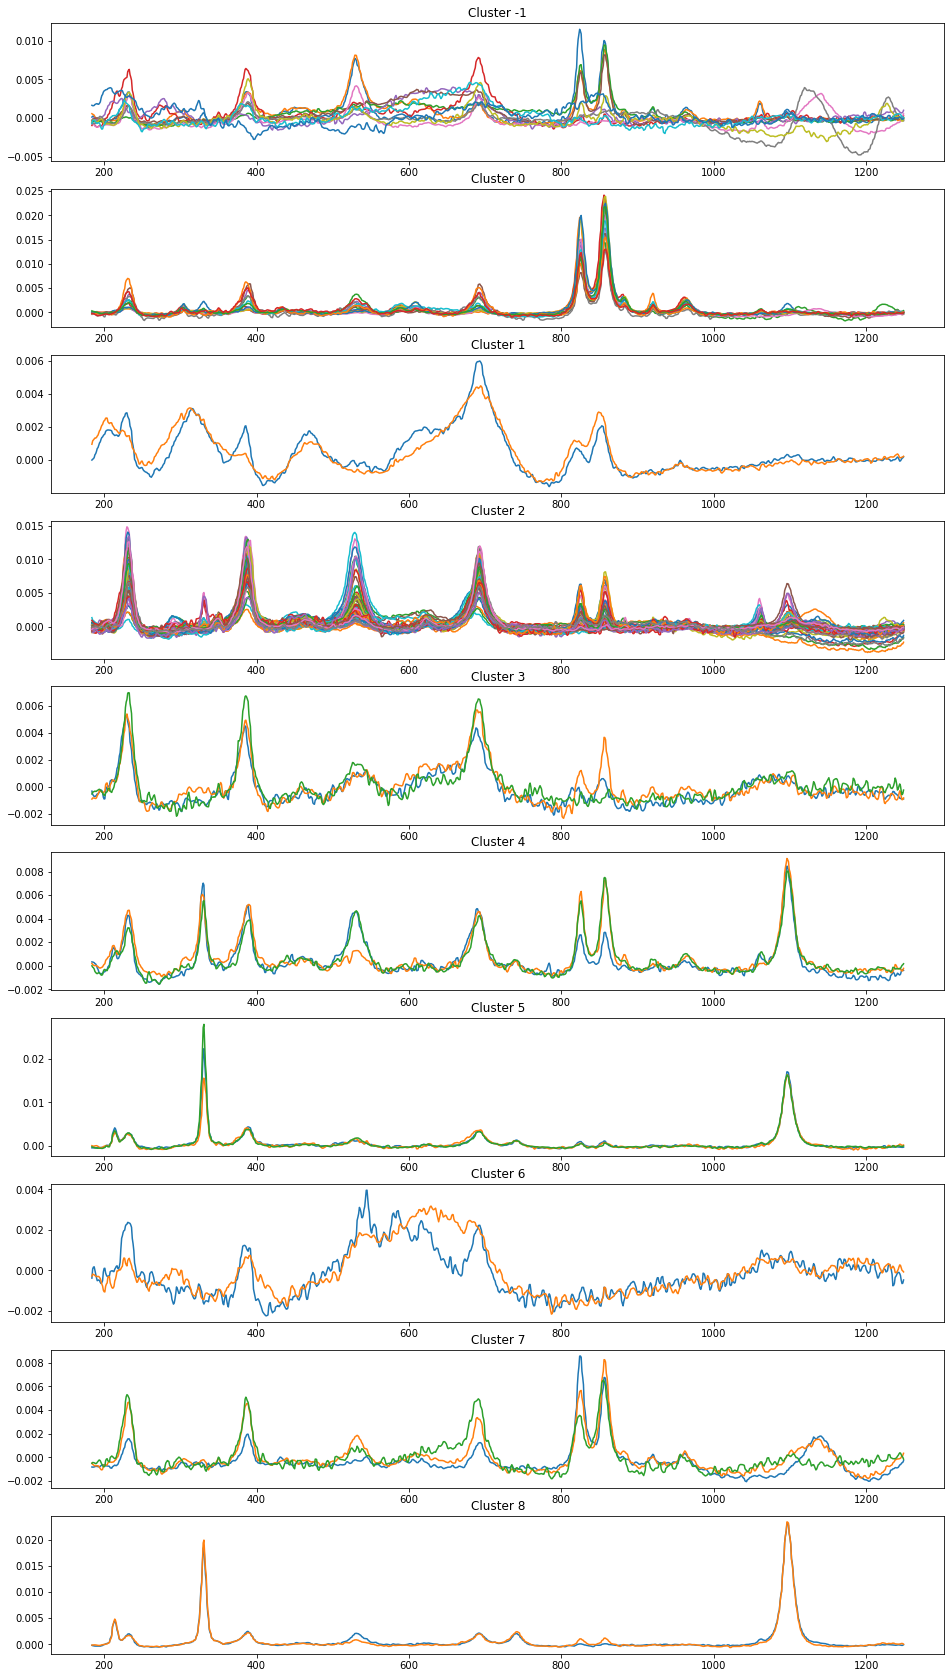

In [5]:
cluster_DB = DBSCAN(eps=0.025, min_samples=2)
cluster_DB.fit(data_t)
cluster_plot(names,cluster_DB.labels_,data)

## Clustering con KMEANS
Abbiamo capito dunque che il clustering non è ben definito, nel senso che non è univoco il modo in cui possiamo definire materiali diversi, dato che le abbondanze variano in modo continuo.

Un algoritmo che non si basà sulle densità ci sembra dunque più adeguato dato che permette di distinguere concentrazioni diverse (scegliendo un bound per la dimensione dei cluster o, come in questo caso, scegliendo il numero di cluster). Utilizziamo quì KMEANS, algoritmo visto a lezione. 

Il vantaggio è che questo non "insegue" zone continue dei cluster ma si limita a disegnare sfere nello spazio delle features minimizzando la varianza del cluster, proprio ciò che ci serve!

Dovremmo peò, in base a ciò che dobbiamo fare, scegliere un numero di cluster adeguato.

Mostriamo ora un esempio del funzionamento di questo algoritmo imponendo 10 clusters. Capiamo che anche in questo caso l'algoritmo raggruppa picchi con altezze diverse, ma a differenza di prima ora abbiamo un raggruppamento con altezze dei picchi che non variano tra la loro altezza massima e zero.

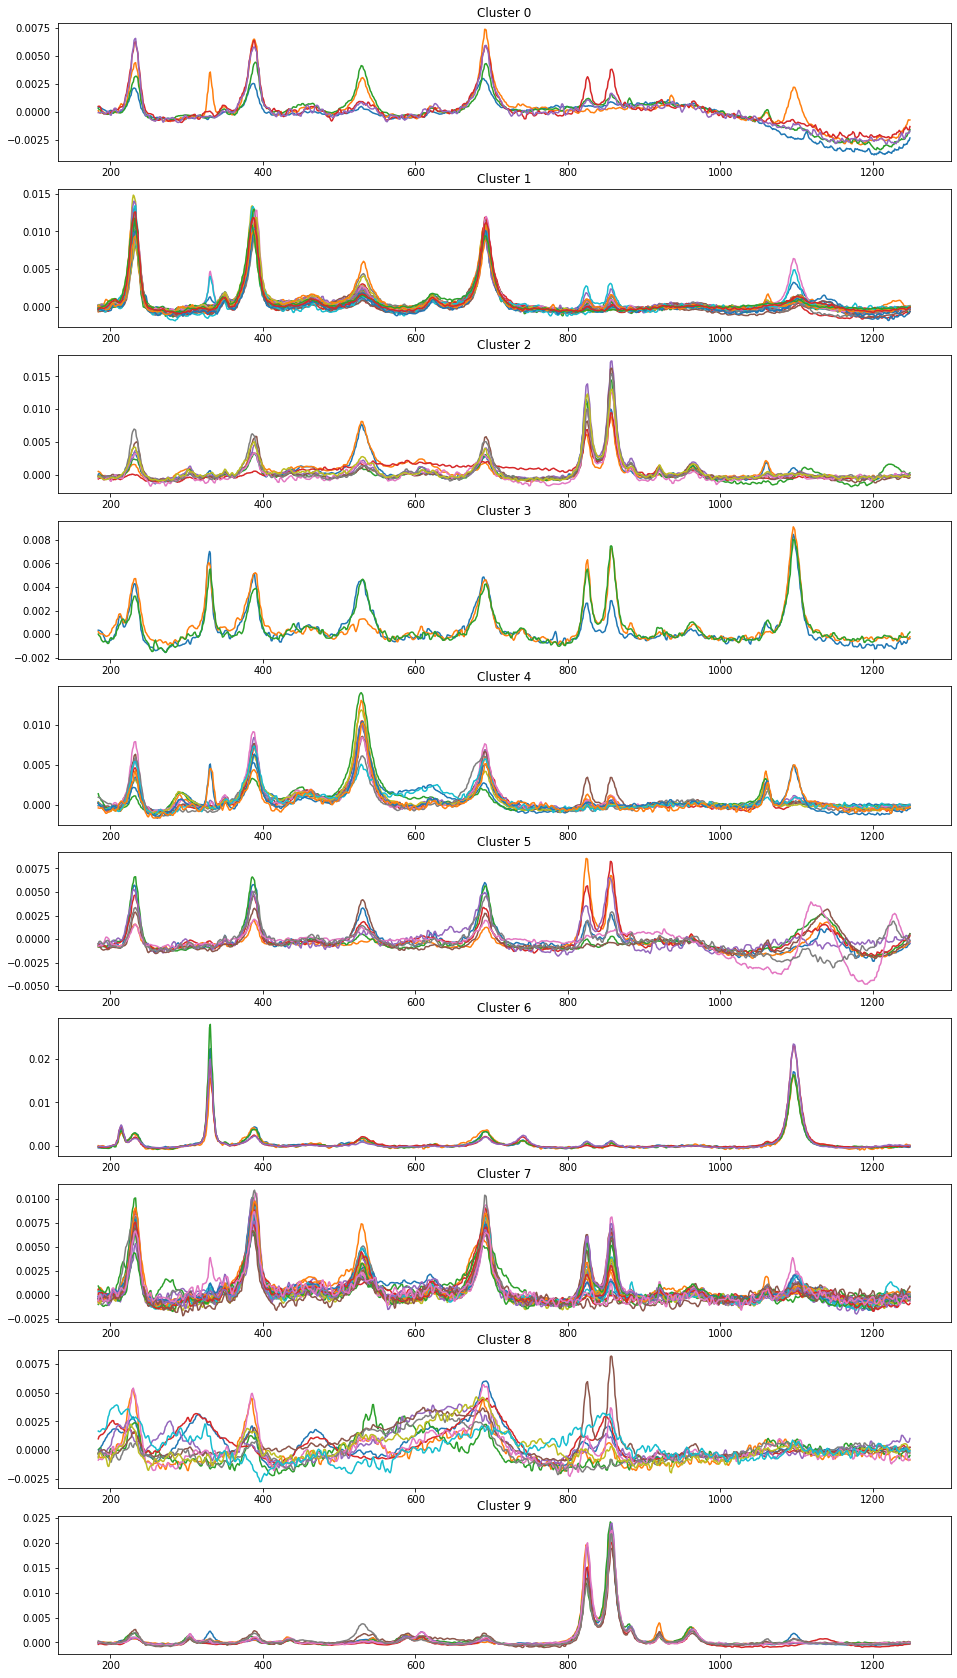

In [6]:
cluster_KM = KMeans(n_clusters=10,max_iter=6000,tol=0.00001)
cluster_KM.fit(data_t)
label = cluster_KM.labels_
cluster_plot(names,label,data)

Andiamo poi a vedere i centroidi di questi clusters. 

Notiamo immediatamente come questi siano meno rumorosi rispetto agli spettri singoli del campione.

Nella seconda parte del progetto siamo interessati, mediante un FIT che utilizza gli spettri dei materiali puri, a calcolare la concentrazione di materiali diversi nel campione.

Sebbene i centroidi, a causa del fatto che le altezze degli spettri variano in modo continuo, non siano una media di dati provenienti da una stessa distribuzione (dunque non rappresentano esattamente le altezze originarie degli spettri) presentano un rumore di fondo soppresso grazie alle medie. 

Scegliamo dunque di utilizzare questi per il calcolo delle concentrazioni (FIT), utilizzando un numero di cluster più grande per ridurre questo problema. Dato che siamo interessati a trovare le abbondanze principali di materiale ciò non introduce un'approssimazione preoccupante mentre dall'altra parte ci permette di anientare il rumore.

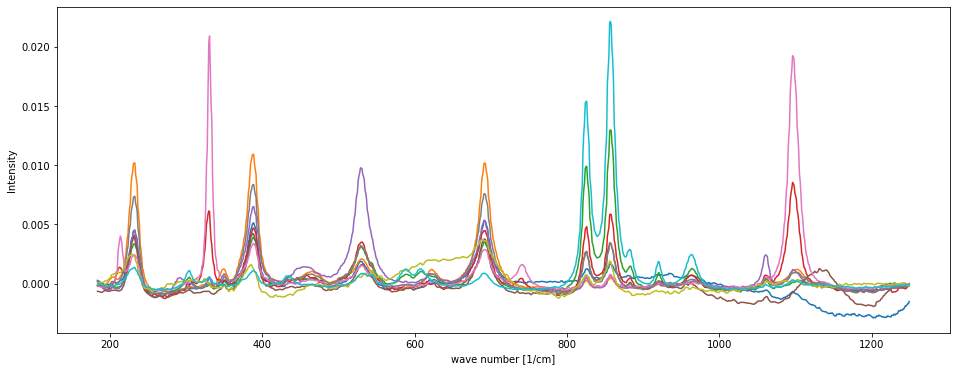

In [7]:
raman_plot()
for temp in np.unique(label):
    plt.plot(data.wn,cluster_KM.cluster_centers_[temp])

## Il risultato del clustering correla con la posizione?
Vogliamo ora capire se esiste una correlazione spaziale nella cluserizzazione. Questo corrispondde al chiedersi se punti vicini hanno materiali simili. Per fare ciò sceglaimo di utilizzare un basso numero di cluster (5), in modo di poter avere una corrispondenza visiva su una griglia $11x11$. **Questa scelta equivale a ritenere uguali materiali con abbondanze piuttosto diverse.** 

Di seguito il risultato del clustering con KMeans (#cluster=5).

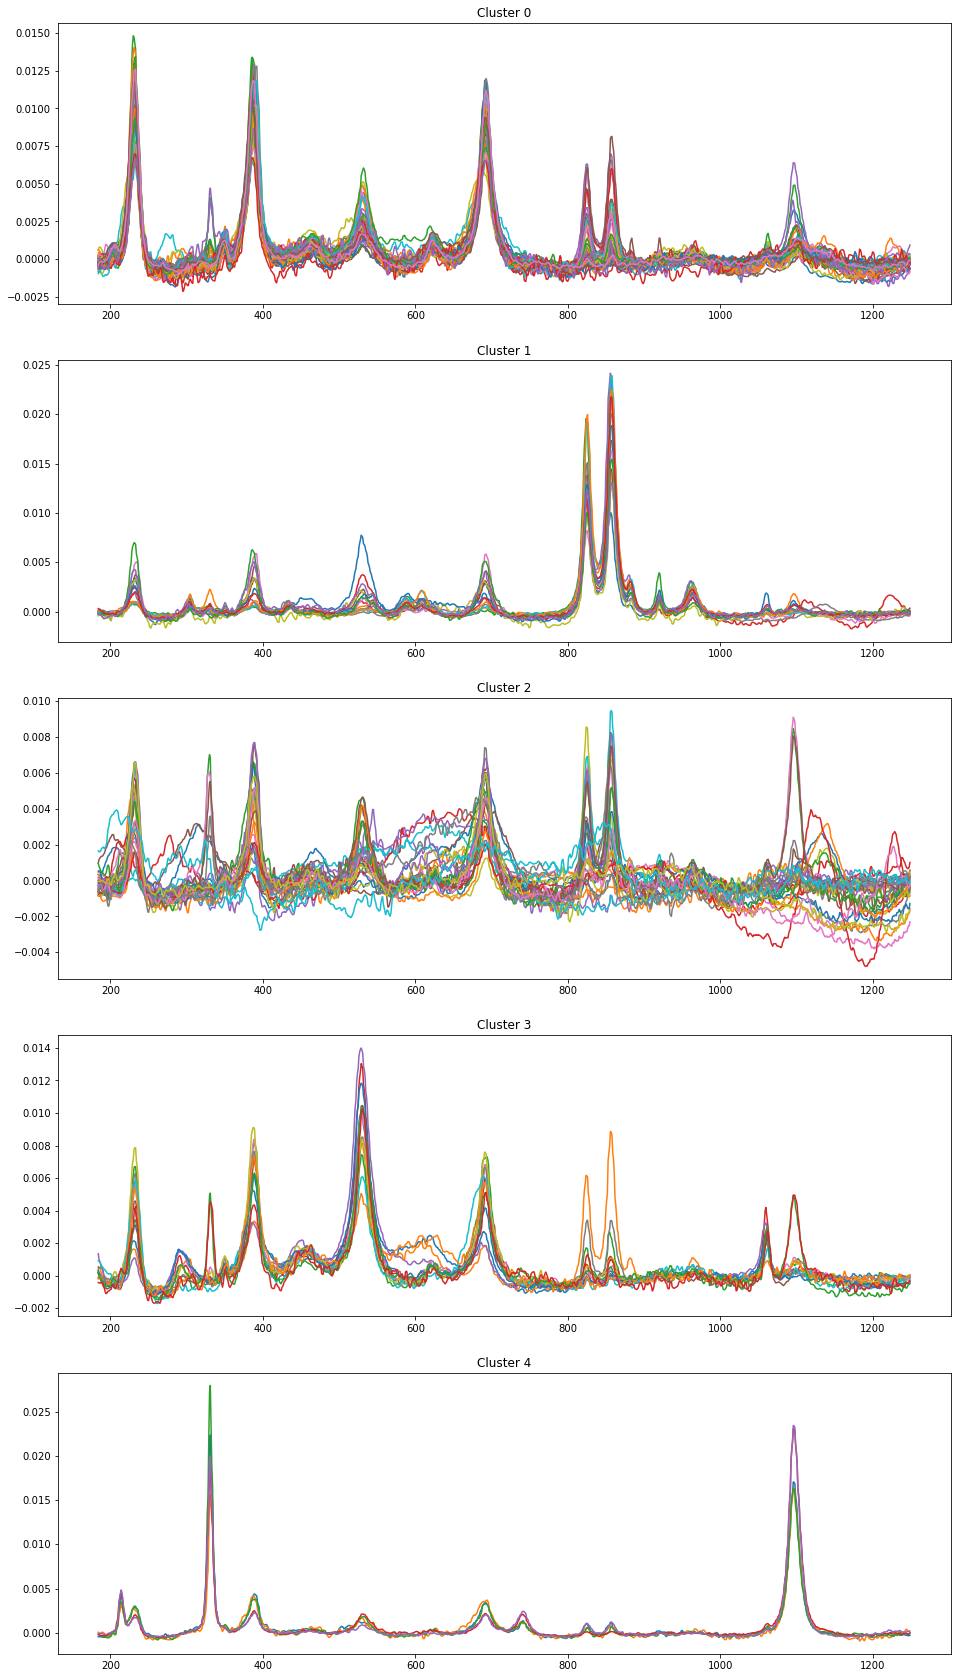

In [8]:
cluster_KM = KMeans(n_clusters=5,max_iter=6000,tol=0.0001)
cluster_KM.fit(data_t)
label = cluster_KM.labels_
cluster_plot(names,label,data)

Andiamo ora a vedere visivamente se il risultato del clustering correla con la posizione. Effettuiamo un plot su una grilgia 11x11 che mostra la clusterizzazione con colori diversi. Visivamente non sembra di vedere abbondanze particolari (attenzione a non confondere abbondanze con correlazioni).

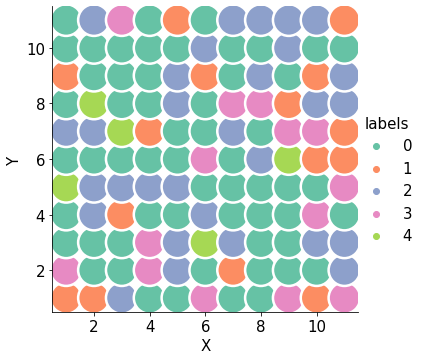

In [9]:
grid_plot(label)

### Definizione di correlazione spaziale
Per descrivere in modo quantitativo la correlazione utilizziamo il coeficiente di Moran (vedi definizione alla [pagina Wikipedia](https://en.wikipedia.org/wiki/Moran%27s_I)). La metrica che utilizziamo è un *nearest neighbour*. Di seguito degli esempi che spiegano in modo pratico questo indice.
#### Esempi

**Esempio con una matrice Random 11x11 (P($\in$cluster)=$\frac{1}{2}$)**

Un esempio di cluster completamente random, notare come il coeficiente di Morange sia circa 0.

Il coeficiente di Morange di un reticolo random 11x11 è -0.0046


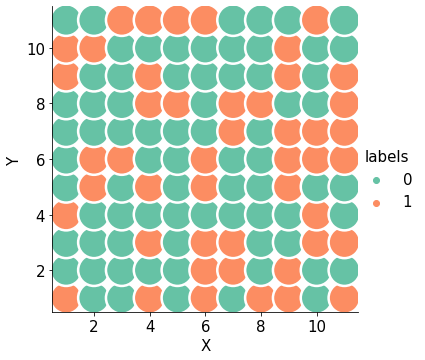

In [10]:
Z=np.random.randint(0,2,(11,11))
w = pysal.lib.weights.lat2W(Z.shape[0], Z.shape[1])
moran = pysal.explore.esda.Moran(Z, w)

grid_plot(Z.reshape(121))
print(f'Il coeficiente di Morange di un reticolo random 11x11 è {round(moran.I,4)}')


**Esempio di alta correlazione: metà reticolo nel cluster(10x5), metà no (10x5)**

Quì un esempio di un cluster evidentemente molto correlato spazialmente, notare come il coeficiente di Morange è vicino a 1.

Il coeficiente di Morange di un reticolo random 11x11 è 0.9028


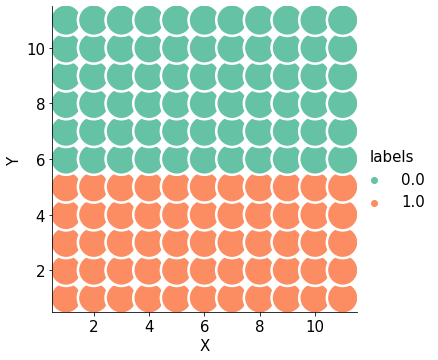

In [11]:
A=np.ones((5,11))
B=np.zeros((6,11))
Z=np.concatenate((A,B))
w = pysal.lib.weights.lat2W(Z.shape[0], Z.shape[1])
moran = pysal.explore.esda.Moran(Z, w)
# Verify Moran's I results

grid_plot(Z.reshape(121))
print(f'Il coeficiente di Morange di un reticolo random 11x11 è {round(moran.I,4)}')

**Esempio di alta correlazione: caso in cui il cluster è piccolo**

Notiamo qui infine che il coeficiente di Morange tende a uno anche nel caso di un cluster piccolo e compatto (correlato spazialmente). Vogliamo evidenziare qui che questo coeficiente non dipende dal numero di punti nel cluster rispetto al numero di punti del reticolo.

Il coeficiente di Morange di un reticolo random 11x11 è 0.7516


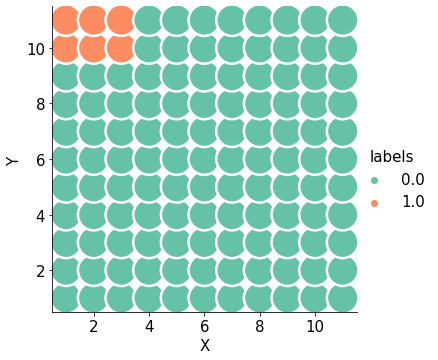

In [12]:
A=np.zeros((9,11))
B=np.ones((2,3))
C=np.zeros((2,8))
Z=np.concatenate((A,np.concatenate((B,C),axis=1)))
w = pysal.lib.weights.lat2W(Z.shape[0], Z.shape[1])
moran = pysal.explore.esda.Moran(Z, w)
# Verify Moran's I results

grid_plot(Z.reshape(121))
print(f'Il coeficiente di Morange di un reticolo random 11x11 è {round(moran.I,4)}')

### Coeficiente di Morange per i nostri clusters
Andiamo a calcolare i coeficienti di Morange per i nostri cluster. Chiaramente ne dobbiamo calcolare uno per cluster. I coefficienti di Moran sono scritti nelle labels.

Come si vedeva visivamente i cluster sono scarsamente correlati spazialmente. Questo può significare che la distanza tra i punti su cui abbiamo effettuato gli spettri Raman sono molto più distanti della dimensione dei agglomerati di materiali uguali.

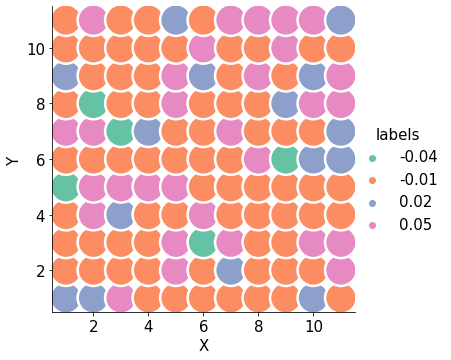

In [13]:
clust_mat=label.reshape(11,11)
w = pysal.lib.weights.lat2W(clust_mat.shape[0], clust_mat.shape[1]) #genero i pesi (neares neighbours)
Imoran=[]
for a in np.unique(label):
    temp=clust_mat.copy()
    for i in range(0,11):
        for j in range (0,11):
            if temp[i,j]==a:
                temp[i,j]=1
            else:
                temp[i,j]=0
    moran=pysal.explore.esda.Moran(temp, w)
    Imoran.append(moran.I)
labels_moran=[round(Imoran[i],2) for i in label]
grid_plot(labels_moran)

## Utilizziamo i centroidi per effettuare i FIT ai materiali puri
### Come scegliere il numero di cluster?
Vogliamo utilizzare la clasterizzazione per rimuovere il rumore dagli spettri, mediando sul cluster (utilizzando i centroidi).

Per scegliere il numero di cluster andiamo a vedere come varia l'errore della clusterizzazione al variare del numero di cluster(attributo "inertia" della classe KMeans). 

Come abbiamo visto a lezione ci aspettiamo una zona a decrescenza a rapida e una a decrescenza più lenta, vogliamo lavorare sul ginocchio di questa curva. Abbiamo tentato deggli approci per automatizzare questa scelta in modo che dipenda solo dalla forma del grafico, ma non ci siamo riusciti. Alla fine abbiamo posto come stop un bound alla decrescita dell'errore sui cluster.

In [14]:
cluster_KM = KMeans(n_clusters=6,max_iter=6000,tol=1e-4)
cluster_KM.fit(data_t);

In [15]:
n_cluster=30 # max number of clusters
inertia=[]
for i in range(n_cluster):
    a=i+3
    cluster_KM = KMeans(n_clusters=a,max_iter=6000,tol=1e-4)
    cluster_KM.fit(data_t)
    inertia.append(cluster_KM.inertia_)

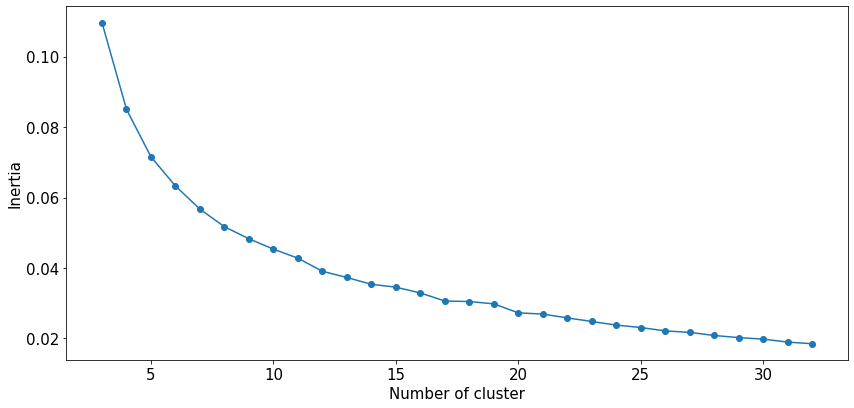

In [16]:
font = {'size': 15}
plt.rc('font',**font)
plt.figure(figsize=(14,6.5))
plt.scatter(list(np.array(range(n_cluster))+3),inertia)
plt.plot(list(np.array(range(n_cluster))+3),inertia)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia");

Dal plot si distingue chiaramente la zona a decrescenza rapida da quella a decrescenza più lenta.

Per scegliere il numero esatto di cluster da utilizzare per la classificazione procediamo in questa maniera:

1. Fissiamo una soglia --> bound
2. Aumentiamo il numero di cluster fino a che la differenza tra le inertia delle clusterizzazioni con n e con n+1 cluster risulta minore della soglia.

Con questa strategia riusciamo ad automatizzare la procedura, ma **in ogni caso il grafico dell'inertia andrebbe controllato visimanete per poter se la soglia riuslta essere corretta**, questo bound non è completamente indipendente dalla curva.

Scegliamo di utilizzare 17 clusters


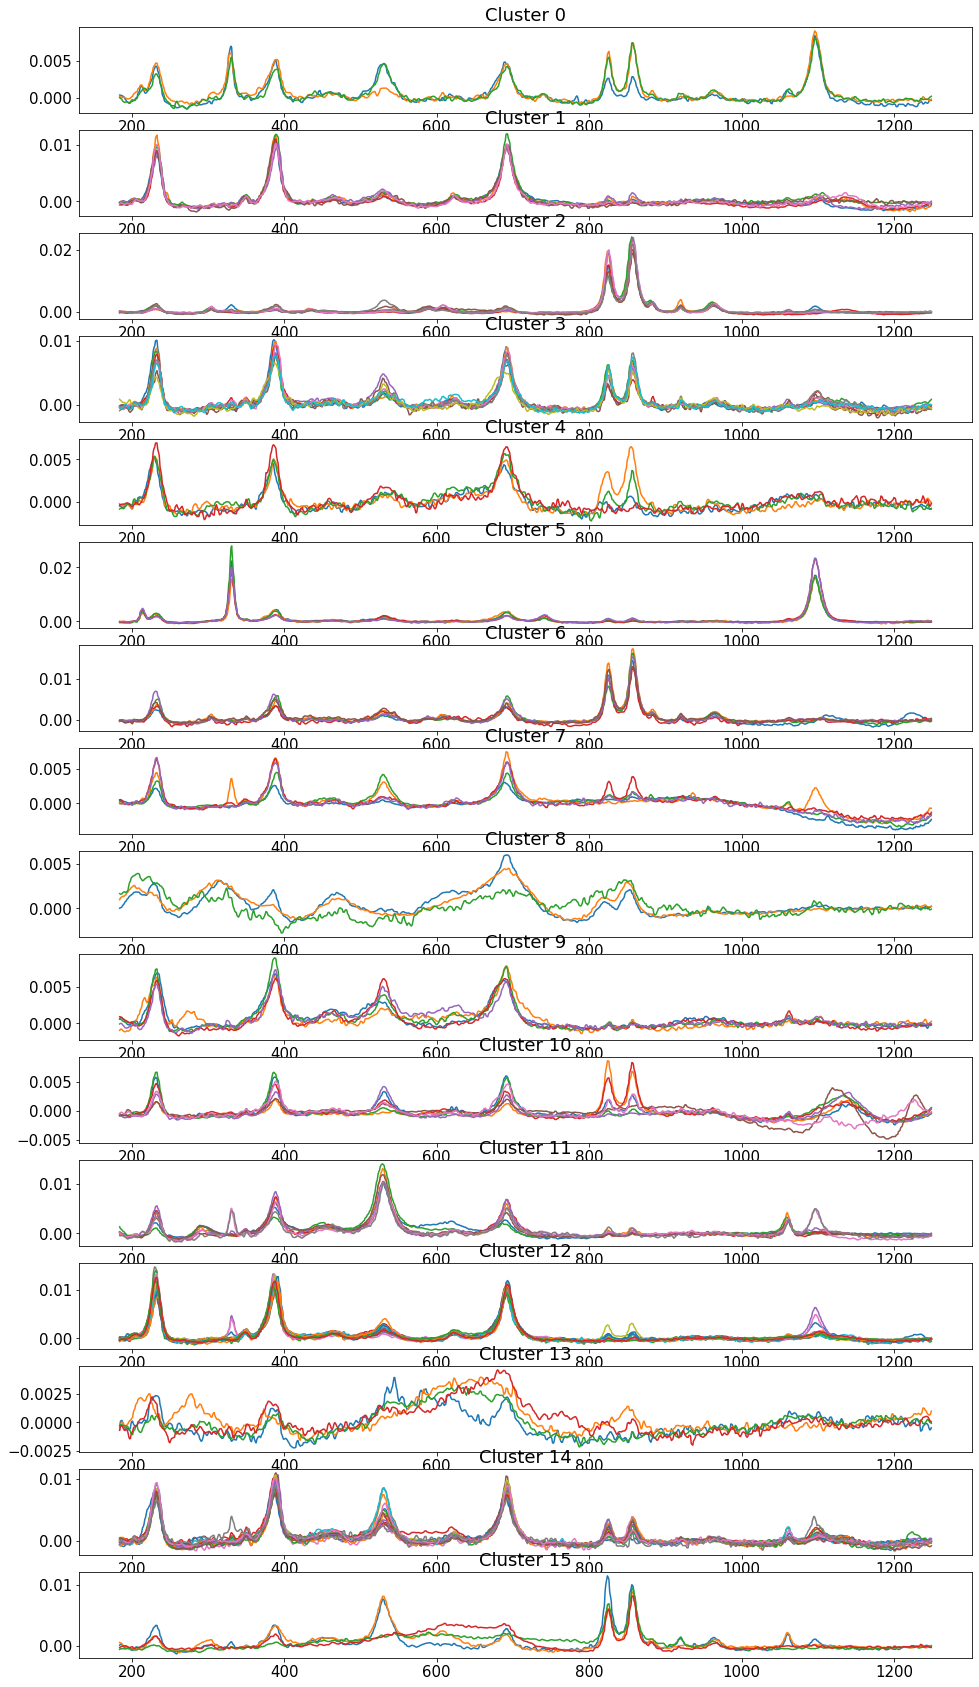

In [22]:
bound = 0.001

diff = bound+1
cluster_KM = KMeans(n_clusters=4,max_iter=6000,tol=1e-4)
cluster_KM.fit(data_t)
i=5
while diff > bound:
    a=cluster_KM.inertia_
    cluster_KM = KMeans(n_clusters=i,max_iter=600,tol=1e-4)
    cluster_KM.fit(data_t)
    b=cluster_KM.inertia_
    diff=abs(a-b)
    i+=1
label=cluster_KM.labels_
n_cluster = i
print(f"Scegliamo di utilizzare {n_cluster} clusters")
cluster_plot(names,label,data)

Di questo clustering teniamo i centroidi, con i quali fitteremo gli spettri puri. Di seguito plottiamo i centroidi. Infine li salviamo in un pandas dataframe in modo da usarli per il riconoscimento dei materiali insieme alle labels, che ci danno i pesi dei vari clusters.

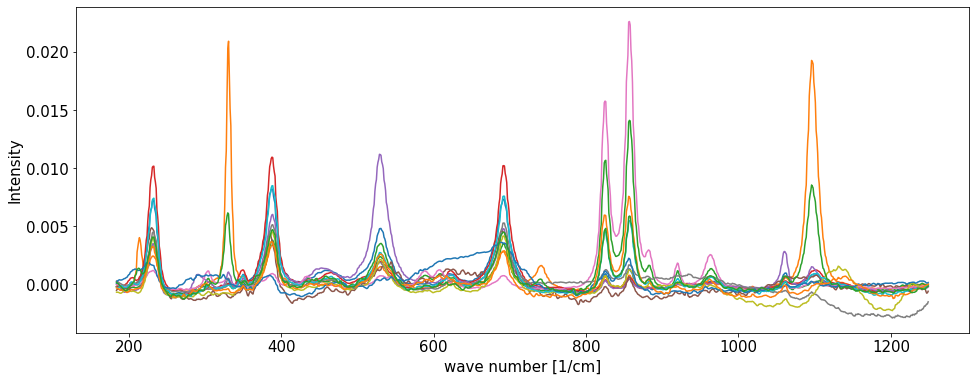

In [19]:
raman_plot()
for temp in np.unique(label):
    plt.plot(data.wn,cluster_KM.cluster_centers_[temp])

In [20]:
# genero un pandas dataframe
centres=pd.DataFrame(data.wn.copy())
for i in range(len(np.unique(label))):
    centres=centres.join(pd.DataFrame(cluster_KM.cluster_centers_[i],columns=[str(i)]))

In [21]:
centres.to_csv("../data/processed/CLUSTERING_data_centres.csv")
np.savetxt("../data/processed/CLUSTERING_labels.txt",label)